In [1]:
import sys
sys.path.append("..")
sys.path.append("../src/dataset/")
sys.path.append("../src/models/")
sys.path.append("../src/utils/")

In [2]:
from dataset import dataset
data = dataset(data_from='disk')

In [4]:
import torch
import torch.nn as nn
import numpy as np
# import torchvision.datasets as datasets
# import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch import optim

In [5]:
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        self.latent_dim = latent_dim
        
        self.model = nn.Sequential(
            nn.Linear(5, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 512),
            nn.ReLU(True),
            nn.Linear(512, 256),
            nn.ReLU(True),
            nn.Linear(256, 5),
            nn.Tanh()
        )
        
    def forward(self, inputs):
        d = self.model(inputs)
        # d = d.view(d.size(0), *self.data_shape)
        return d
    
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(5, 512),
            nn.ReLU(True),
            nn.Linear(512, 256),
            nn.ReLU(True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
        
    def forward(self, d):
        # d_flat = d.view(d.size(0), -1)
        validity = self.model(d)
        return validity

In [55]:
latent_dim = 4
batch_size = 64
lr = 1e-8
b1 = 0.5
b2 = 0.9
n_epochs = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [56]:

train_dataloader = DataLoader(torch.tensor(data.X_train[data.y_train == 0][:1_000, :]), batch_size=batch_size, shuffle=True)
generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)

In [57]:
adversarial_loss = nn.MSELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas = (b1, b2))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas = (b1, b2))

In [58]:
from tqdm import tqdm
g_losses = []
d_losses = []
print(f"Device:", device)

for epoch in tqdm(range(n_epochs), desc="Training"):
    for i, d in enumerate(train_dataloader):
        # adversarial ground truth
        _d_loss = []
        _g_loss = []
        valid = torch.ones((d.size(0), 1), requires_grad = False).to(device)
        fake = torch.zeros((d.size(0), 1), requires_grad = False).to(device)
        # train generator
        optimizer_G.zero_grad()
        # z = torch.randn((d.size(0), latent_dim)).to(device)
        gen_data = generator(d)
        d_fake = discriminator(gen_data)
        g_loss = adversarial_loss(d_fake, valid)
        g_loss.backward()
        optimizer_G.step()
        _g_loss.append(g_loss.item())
        # train discriminator
        optimizer_D.zero_grad()
        d_real = discriminator(d.to(device))
        d_fake = discriminator(gen_data.detach())
        d_loss = 0.5*(adversarial_loss(d_real, valid) + adversarial_loss(d_fake, fake))
        d_loss.backward()
        optimizer_D.step()
        _d_loss.append(d_loss.item())
        # print progress
    g_losses.append(g_loss.item())
    d_losses.append(d_loss.item())
    # print(f"Epoch {epoch+1}/{n_epochs} [Batch {i}/{len(train_dataloader)}] [D loss: {d_loss.item():.4f}] [G loss: {g_loss.item():.4f}]")

Device: cpu


Training: 100%|██████████| 100/100 [00:30<00:00,  3.31it/s]


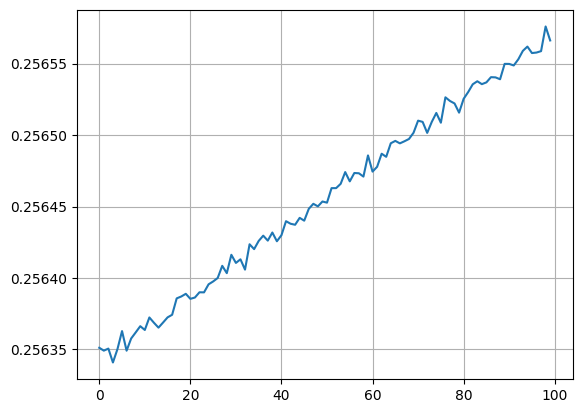

In [59]:
import matplotlib.pyplot as plt
plt.plot(g_losses, label="Generator")
plt.grid()
plt.show()

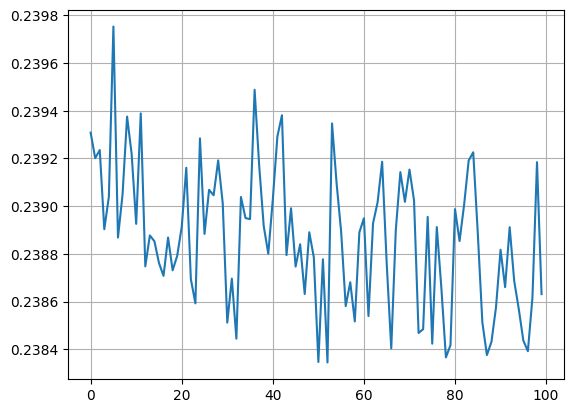

In [60]:
plt.plot(d_losses, label="Discriminator")
plt.grid()
plt.show()

In [15]:
def compute_score(d):
    valid = torch.ones((d.size(0), 1), requires_grad = False).to(device)
    gen_data = generator(d)
    d_fake = discriminator(gen_data)
    score = adversarial_loss(d_fake, valid)
    return score

In [22]:
gen_data = generator(d)

In [17]:
valid_data_signal = torch.tensor(data.get_valid_signal(size=5000))
valid_data_background = torch.tensor(data.get_valid_background(size=5000))
pred_signal = generator(valid_data_signal)
pred_background = generator(valid_data_background)

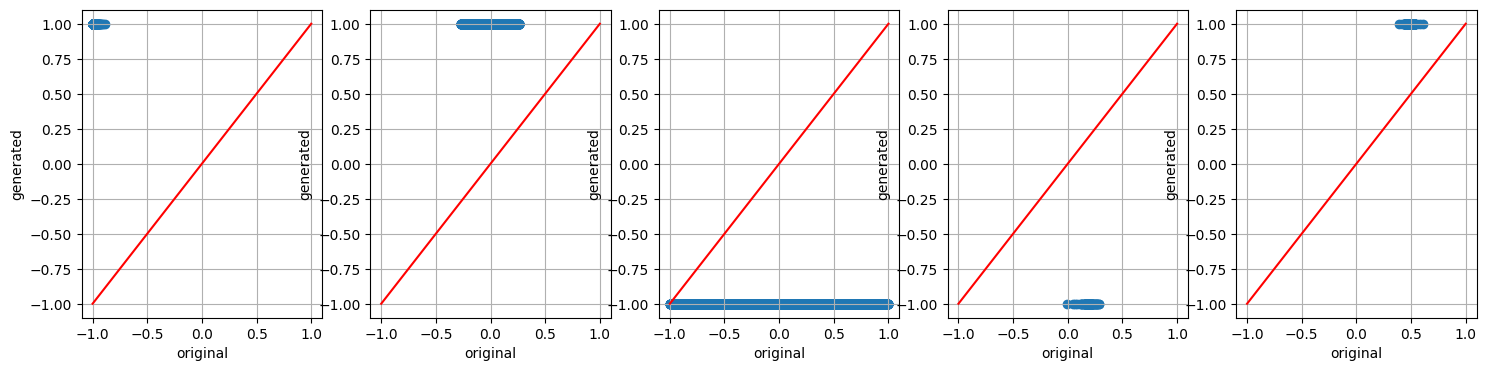

In [23]:
fig, axs = plt.subplots(1,5, figsize=(18,4))
for i in range(5):
    x = valid_data_background.detach().numpy()[:, i]
    y = pred_background.view(valid_data_background.shape).detach().numpy()[:, i]
    axs[i].scatter(x, y)
    axs[i].set_xlabel("original")
    axs[i].set_ylabel("generated")
    axs[i].grid()
    # axs[i].set_xlim((min(x), max(x)))
    # axs[i].set_ylim((min(y), max(y)))
    axs[i].plot([-1,1], [-1,1], color='red')
plt.show()

In [ ]:
plt.plot

In [29]:
err_signal = [nn.MSELoss()(valid_data_signal.view(pred_signal.shape)[i], pred_signal[i]).item() for i in range(5000)]
err_background = [nn.MSELoss()(valid_data_background.view(pred_background.shape)[i], pred_background[i]).item() for i in range(5000)]

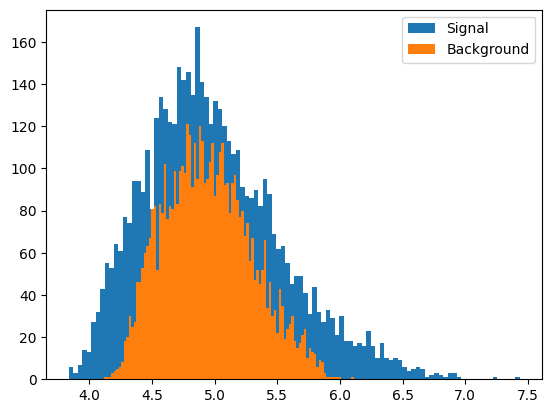

In [32]:
plt.hist(err_signal, label="Signal", bins=100)
plt.hist(err_background, label="Background", bins=100)
plt.legend()
plt.show()

In [8]:
np.concatenate((data.X_test, data.X_valid)).min(axis=0)

array([-0.9999937 , -1.        , -0.9999986 , -0.20390958,  2.8273478 ],
      dtype=float32)

In [10]:
np.max(data.X_train, axis=0)

array([0.24519145, 2.981267  , 3.0000014 , 3.917471  , 6.811629  ],
      dtype=float32)